# Demo: Blob Detection in Dask 

In [1]:
from dask_image.ndfeature import blob_log,blob_dog,blob_doh
import dask.array as da


from skimage import data
from skimage.color import rgb2gray
from skimage.feature import blob_log as ski_blob_log
from skimage.feature import blob_doh as ski_blob_doh
from scipy.ndimage import gaussian_filter, gaussian_laplace
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np

### Functions to generate and display randomly generated gaussian blobs

In [2]:
def generate_blobimage(shape, blobs):
    """function to generate blob images from an image shape and blob
    coordinates and sigmas

    :param shape:shape of image to generate
    :param blobs: array with blob coordinates and sigma in last column"""

    img = np.zeros(shape, dtype=np.float32)
    if blobs is None:
        return img
    for blob in blobs:
        tmp_img = np.zeros(shape, dtype=np.float)
        tmp_img[tuple(blob[:-1])] = 1.0
        gaussian_filter(tmp_img, blob[-1], output=tmp_img)
        tmp_img = tmp_img / np.max(tmp_img)
        img += tmp_img
    return img

def random_blobs(shape,nblobs,sigma_range,seed=123):
    """function to generate image with random blobs"""
    blobs = []
    np.random.seed(seed)
    for dim in shape:
        blobs.append(np.random.randint(0, dim, nblobs))

    blobs.append(np.random.randint(sigma_range[0], sigma_range[1], nblobs))
    blobs = np.asarray(blobs).T
    img = generate_blobimage(shape,blobs)
    return img, blobs

def show_circle_blobs(img, blobs):
    """function to circle blobs in img"""
    plt.figure(figsize=(10,10))
    plt.imshow(img,cmap='Greys_r')
    ax = plt.gca()
    plt.axis('off')
    for blob in blobs:
        y, x = blob[:2]
        r = blob[-1]
        c = plt.Circle((x, y), r*sqrt(2), color='red', linewidth=2, fill=False)
        ax.add_patch(c)

Let's generate a random set of gaussian blobs:

[[331 384   6]
 [155 373   5]
 [390 104   7]
 [253 204   3]
 [241 269   7]
 [130  82   2]
 [259  89   2]
 [451 291   5]
 [332 446   5]
 [432 100   3]
 [278 419   5]
 [ 49 417   2]
 [436 158   3]
 [389 119   3]
 [141 447   2]
 [473 352   6]
 [418 146   2]
 [459 470   6]
 [118 434   3]
 [ 74 208   5]]


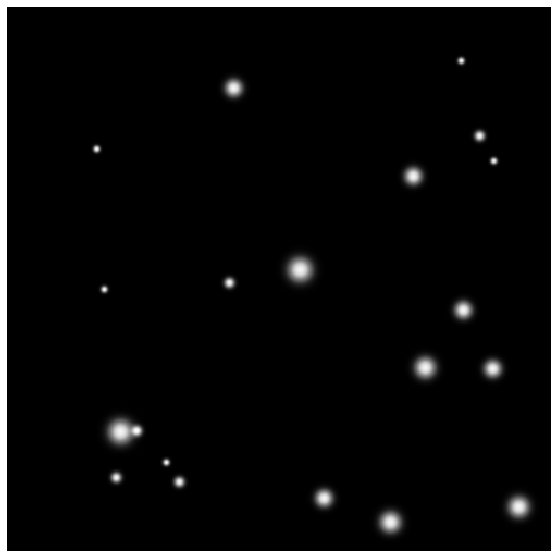

In [3]:
img,expected = random_blobs((500,500),20,(2,8),12)
print(expected)
plt.figure(figsize=(10,10))
plt.imshow(img,cmap='Greys_r')
plt.axis('off');

Demonstration of Laplacian of Gaussian transformation

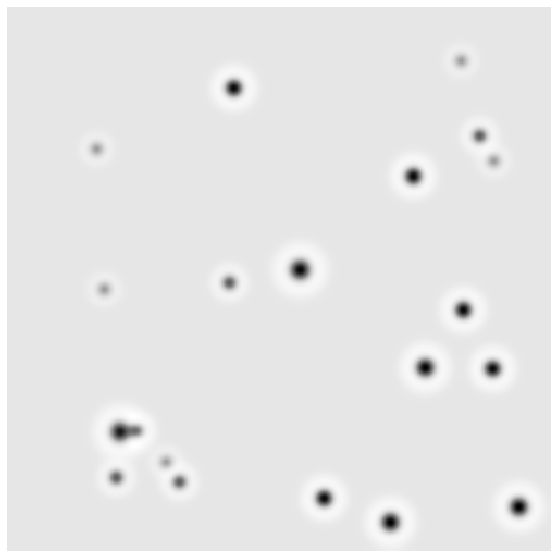

In [14]:
log_img = gaussian_laplace(img,sigma=6)
plt.figure(figsize=(10,10))
plt.imshow(log_img,cmap='Greys_r')
plt.axis('off');

### convert the image to a dask array and run blob prediction on it

In [4]:
dsk_img = da.from_array(img,chunks=(250,250))

Laplacian of Gaussian Method:

CPU times: user 4.7 s, sys: 650 ms, total: 5.35 s
Wall time: 2.42 s


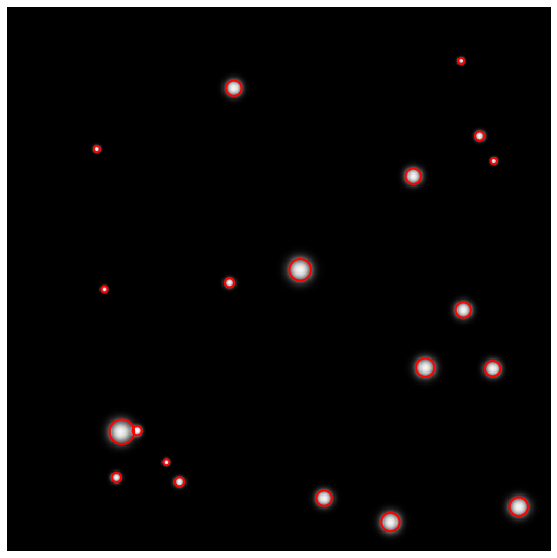

In [5]:
%%time
blobs_log = blob_log(dsk_img,min_sigma=1,max_sigma=10,num_sigma=10)

show_circle_blobs(img,blobs_log)

Difference of Gaussian Method

CPU times: user 2.01 s, sys: 288 ms, total: 2.29 s
Wall time: 1.14 s


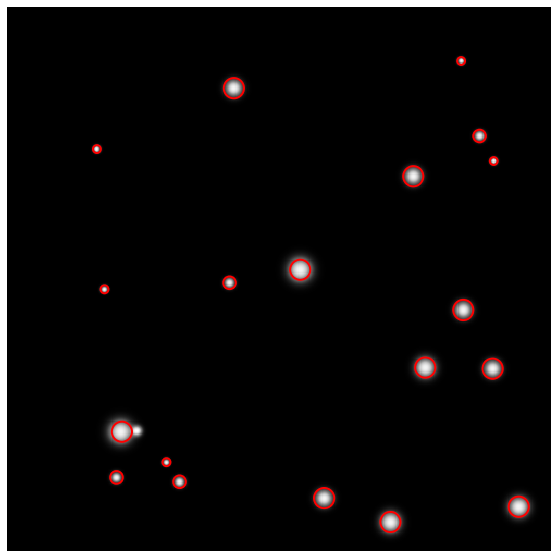

In [6]:
%%time
blobs_dog = blob_dog(dsk_img,min_sigma=1,max_sigma=10)

show_circle_blobs(img,blobs_dog)

Determinant of Hessian Method

CPU times: user 2.69 s, sys: 542 ms, total: 3.23 s
Wall time: 1.96 s


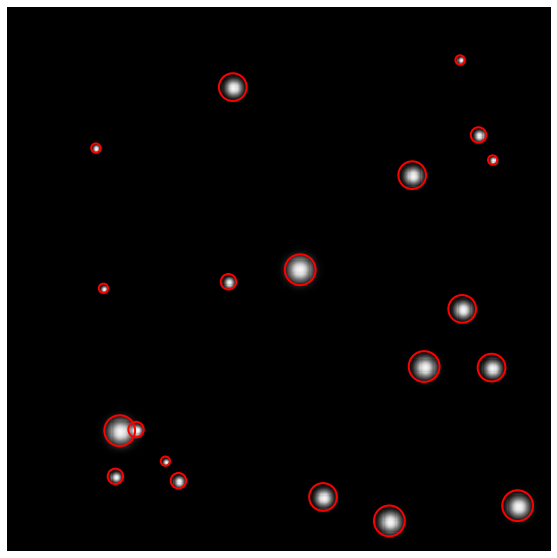

In [10]:
%%time
blobs_doh = blob_doh(dsk_img.astype(np.float64),min_sigma=1,max_sigma=10,num_sigma=10)

show_circle_blobs(img,blobs_doh)

### prediction of stars in telescope data

/Users/gu6/PycharmProjects/dask-image/dask_image/ndfeature/_skimage_utils.py:105: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/Users/gu6/PycharmProjects/dask-image/dask_image/ndfeature/_skimage_utils.py:106: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/Users/gu6/PycharmProjects/dask-image/dask_image/ndfeature/_skimage_utils.py:107: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/Users/gu6/PycharmProjects/dask-image/dask_image/ndfeature/_skimage_utils.py:109: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
/Users/gu6/PycharmProjects/dask-image/dask_image/ndfeature/_skimage_utils.py:105: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/Users/gu6/PycharmProjects/dask-image/dask_image/ndfeature/_skimage_utils.py:106: RuntimeWarning: divide b

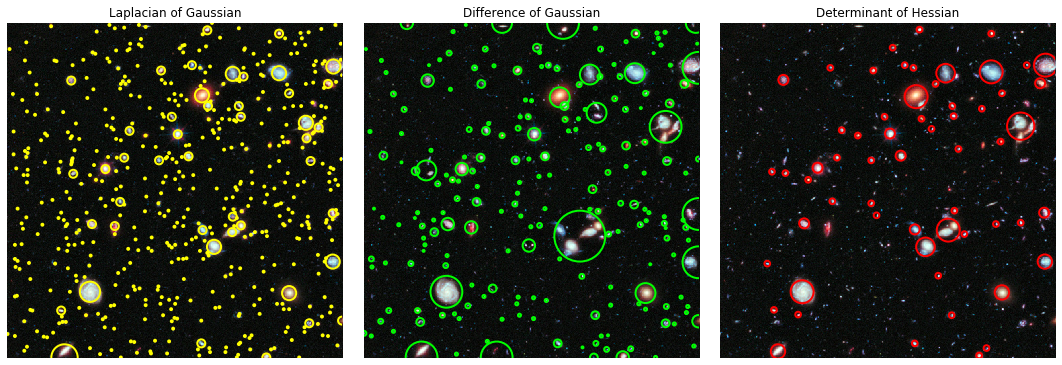

In [11]:
#demo code adapted for dask from https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_blob.html

image = data.hubble_deep_field()[0:500, 0:500]
image_gray = da.from_array(rgb2gray(image),chunks=(250,250))

blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=.1)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(image)
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

### Detecting other round objects

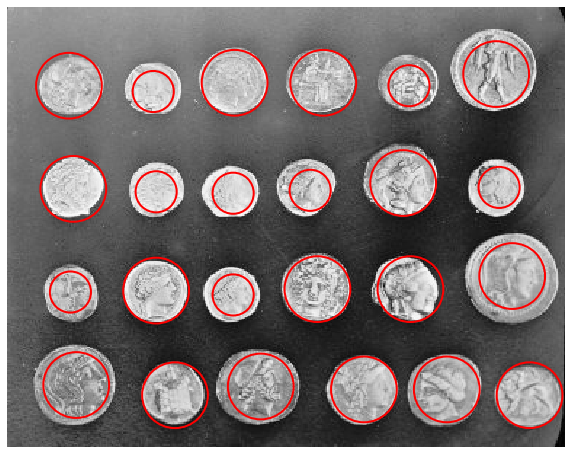

In [13]:
coins = da.from_array(data.coins(),chunks='auto')
coin_blobs = blob_dog(coins,min_sigma=10,max_sigma=40, exclude_border=5)
show_circle_blobs(coins,coin_blobs)